In [32]:
import numpy as np
import torch
import matplotlib.pyplot as plt


def true_function(x):
    f = np.sin(3 * np.pi * (x / 10)) - (0.5 * np.sin(8 * np.pi * (x / 10)))
    f = f * 5
    return f

In [33]:
def RBF(x1, x2, lengthscale: float = 1.0):
    """
    Squared Exponential (RBF) function, used as the covariance function.
    """
    return torch.exp(-.5 * ((torch.as_tensor(x1) - torch.as_tensor(x2)) ** 2) / lengthscale ** 2)

In [34]:

def create_kernel(X1, X2) -> torch.Tensor:
    """
    Function to create an RBF kernel matrix.
    """
    k = torch.zeros(X1.shape[0], X2.shape[0])

    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            k[i][j] = torch.as_tensor(RBF(x1, x2))

    return k.numpy()

## Example of Prior Samples of the kernel

(100, 100)


/var/folders/y1/0c02yr8n54q4hsbwhhl1fvy80000gn/T/ipykernel_29339/200977495.py:11: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  func = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov)


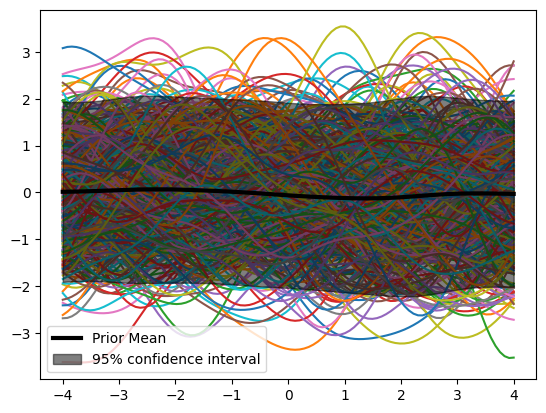

In [50]:

function_samples = 100
num_functions = 500

# Initialise the Covariance Matrix
x = torch.linspace(-4, 4, function_samples)
k = create_kernel(x, x)
print(k.shape)


def sample_prior(cov) -> (torch.Tensor, torch.Tensor):
    func = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov)
    return func

functions = torch.as_tensor([
    sample_prior(k)
    for _ in range(num_functions)
])

for p in range(num_functions):
    plt.plot(x, functions[p])

mu = torch.mean(functions, dim=0)
sigma = torch.std(functions, dim=0)
plt.plot(x, mu, label='Prior Mean', c='k', linewidth=3, zorder=num_functions + 1)
plt.fill_between(
    x,
    mu - 2 * sigma,
    mu + 2 * sigma,
    alpha=0.5,
    color='black',
    label='95% confidence interval',
    zorder=num_functions + 2,
)
plt.legend()
plt.show()

[ 0.83255632  0.18406715 -0.83255632]


/var/folders/y1/0c02yr8n54q4hsbwhhl1fvy80000gn/T/ipykernel_29339/2377478525.py:11: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  function = np.random.multivariate_normal(mu, sigma)


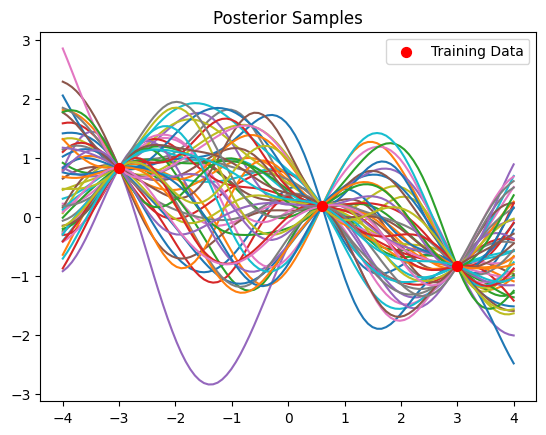

/var/folders/y1/0c02yr8n54q4hsbwhhl1fvy80000gn/T/ipykernel_29339/1386892095.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = np.sin(3 * np.pi * (x / 10)) - (0.5 * np.sin(8 * np.pi * (x / 10)))


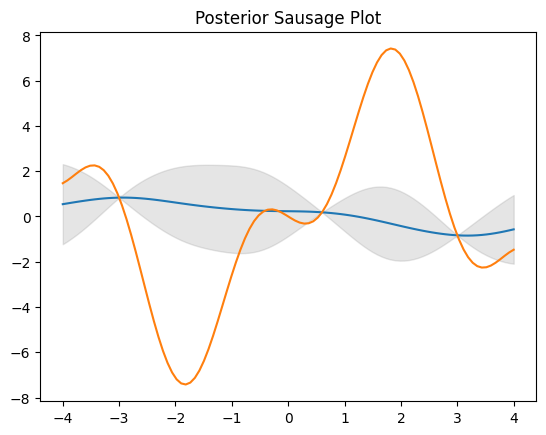

In [36]:

num_functions = 50

def sample_posterior(X_, X, y):
    K_X_X = create_kernel(X_, X)
    K_XX = create_kernel(X, X)
    K_X_X_ = create_kernel(X_, X_)
    K_XX_ = create_kernel(X, X_)

    mu = K_X_X @ np.linalg.inv(K_XX) @ y
    sigma = K_X_X_ - K_X_X @ np.linalg.inv(K_XX) @ K_XX_

    function = np.random.multivariate_normal(mu, sigma)
    return function


X = torch.linspace(-4, 4, 100)
train_X = torch.tensor(np.array([-3, 0.6, 3.]))
train_Y = np.array([true_function(i.item()) for i in train_X])
print(train_Y)

posterior_samples = torch.zeros(num_functions, X.shape[0])

for i, f in enumerate(functions):
    posterior_samples[i] = torch.as_tensor(sample_posterior(X, train_X, train_Y))
    plt.plot(X, posterior_samples[i])

plt.scatter(train_X, train_Y, label="Training Data", c='r', s=50, zorder=posterior_samples.shape[0] + 1)
plt.legend()
plt.title("Posterior Samples")
plt.show()

mu = torch.mean(posterior_samples, dim=0)
sigma = torch.std(posterior_samples, dim=0)

plt.title("Posterior Sausage Plot")
plt.plot(X, mu, label='Posterior Mean')
plt.plot(X, true_function(X), label='True Function')
plt.fill_between(
    X,
    mu - 2 * sigma,
    mu + 2 * sigma,
    alpha=0.2,
    color='grey',
    label='95% confidence interval'
)
plt.show()

### Acquisition Functions


/var/folders/y1/0c02yr8n54q4hsbwhhl1fvy80000gn/T/ipykernel_29339/646974866.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  expected_improvement = Z * sigma * norm.cdf(Z) + sigma * norm.pdf(Z)


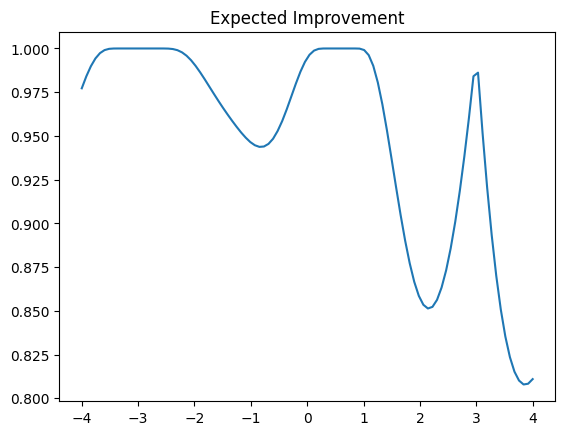

In [37]:
from scipy.stats import norm


def EI(mu, sigma, loss_optimum):
    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = (loss_optimum - mu) / sigma
        expected_improvement = Z * sigma * norm.cdf(Z) + sigma * norm.pdf(Z)

    # Want to maximise this
    return 1 - expected_improvement


y_min = np.min(train_Y)

ei = torch.as_tensor(EI(mu, sigma, y_min))

plt.plot(X, ei)
plt.title("Expected Improvement")
plt.show()

## Optimise the Acquisition Function

### This code is heavily unoptimised and written in python... this will take a while but it works

/var/folders/y1/0c02yr8n54q4hsbwhhl1fvy80000gn/T/ipykernel_29339/1221769832.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ei = - (sigma * s * norm.cdf(mu) + sigma * norm.pdf(s))


-7.423660814106996
[2.14143297]


/var/folders/y1/0c02yr8n54q4hsbwhhl1fvy80000gn/T/ipykernel_29339/2377478525.py:11: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  function = np.random.multivariate_normal(mu, sigma)
/var/folders/y1/0c02yr8n54q4hsbwhhl1fvy80000gn/T/ipykernel_29339/1386892095.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f = np.sin(3 * np.pi * (x / 10)) - (0.5 * np.sin(8 * np.pi * (x / 10)))


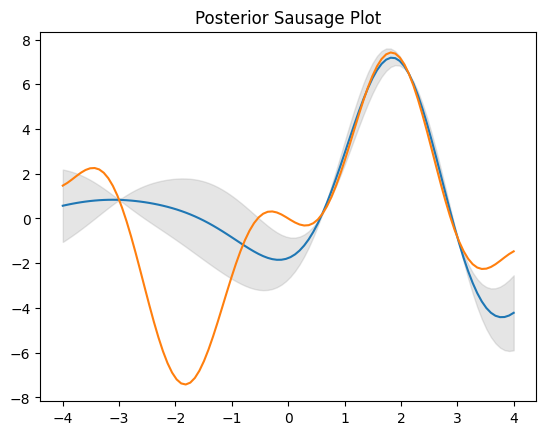

/var/folders/y1/0c02yr8n54q4hsbwhhl1fvy80000gn/T/ipykernel_29339/646974866.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  expected_improvement = Z * sigma * norm.cdf(Z) + sigma * norm.pdf(Z)


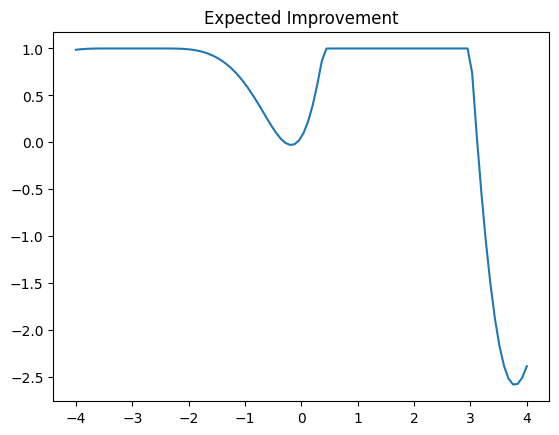

[-1.00184985]


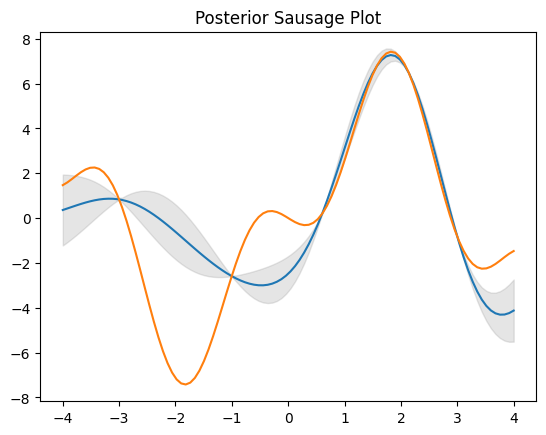

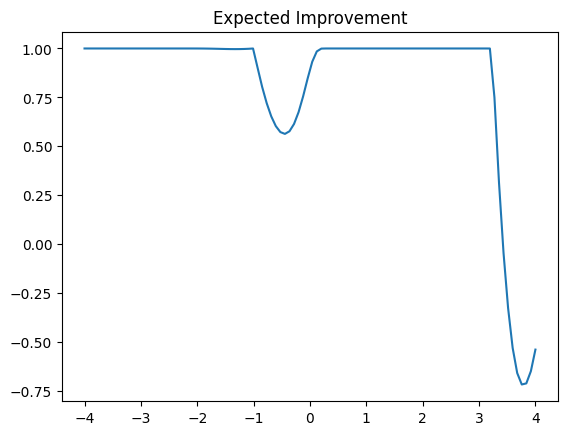

KeyboardInterrupt: 

In [38]:
from scipy.optimize import differential_evolution


def EI_opt(x, train_X, train_Y, f_best):
    x = x.reshape(-1, 1)

    # Make predictions
    num_functions = 100
    posterior_samples = torch.zeros(num_functions, x.shape[0])
    for i in range(num_functions):
        posterior_samples[i] = torch.as_tensor(sample_posterior(x, train_X, train_Y))

    mu = torch.mean(posterior_samples, dim=0)
    sigma = torch.std(posterior_samples, dim=0)

    s = (f_best - mu) / sigma
    ei = - (sigma * s * norm.cdf(mu) + sigma * norm.pdf(s))

    return ei


FE = 0
FE_MAX = 10
X = np.linspace(-4, 4, 100)

train_X = torch.tensor(np.array([-3, 0.6, 3.]))
train_Y = np.array([true_function(i.item()) for i in train_X])

true_min = np.min([true_function(i) for i in X])
print(true_min)
regret = [np.min(train_Y) - true_min]

while FE < FE_MAX:

    f_best = np.min(train_Y)

    bounds = [(-4, 4)]

    results = differential_evolution(
        func=EI_opt,
        args=(train_X, train_Y, f_best),
        bounds=bounds,
    )

    x_new = results.x
    print(x_new)

    y_new = true_function(x_new)
    x_new = x_new.reshape(1, -1)
    y_new = y_new.reshape(-1, 1)
    train_X = np.concatenate((train_X, x_new[0]), axis=0)
    train_Y = np.concatenate((train_Y, y_new[0]), axis=0)

    regret.append(np.min(train_Y) - true_min)

    """
    Plot the new posterior distribution to see what's up
    """
    posterior_samples = torch.zeros(num_functions, X.shape[0])
    X = torch.linspace(-4, 4, 100)
    for i in range(num_functions):
        posterior_samples[i] = torch.as_tensor(sample_posterior(X, train_X, train_Y))

    mu = torch.mean(posterior_samples, dim=0)
    sigma = torch.std(posterior_samples, dim=0)

    plt.title("Posterior Sausage Plot")
    plt.plot(X, mu, label='Posterior Mean')
    plt.plot(X, true_function(X), label='True Function')
    plt.fill_between(
        X,
        mu - 2 * sigma,
        mu + 2 * sigma,
        alpha=0.2,
        color='grey',
        label='95% confidence interval'
    )
    plt.show()
    FE += 1

plt.plot(regret)
plt.xlabel('Iteration')
plt.ylabel('Regret')
plt.show()